<div align="center">
  <img src="https://github.com/Alek050/databallpy/assets/49450063/56100e87-c680-4dc1-82e5-4aa8fdbc8a34" alt="Logo">
</div>

# Loading in a Match

Almost all usable features are centered around the `Match` object. The `Match` essentially contains all information you need to know to get started with your analysis. We will go over all information that is stored here and you might want to use, but lets first load in the match. You can choose to load in a match with your own data, or choose to download a open sourced match. To the match with you own data you can run the following code:

```python
from databallpy import get_match, get_open_match

match = get_match(
  tracking_data_loc="../data/tracking_data.dat",
  tracking_metadata_loc="../data/tracking_metadata.xml",
  tracking_data_provider="tracab"
  event_data_loc="../data/event_data_f24.xml",
  event_metadata_loc="../data/event_metadata_f7.xml",
  event_data_provider="opta",
)

# or get the open match provided by Metrica
match = get_open_match()
```

```{note}
The current supported tracking data providers are:

- Tracab
- Metrica
- Inmotio

The current supported event data provider are:
- Opta
- Metrica
- Instat

If you wish to use a different provider that is not listed here, please open an issue [here](https://github.com/Alek050/databallpy/issues)
```

```{warning}
It is perfectly fine to load your `Match` object with only tracking- or only event data. However, not that some features require both data streams, and will therefore raise an error when called.

```

For the sake of reproducability we will use the open match provided by Metrica in this example:

In [1]:
from databallpy import get_open_match, __version__

print(f"The current version of databallpy is {__version__}")

The current version of databallpy is 0.4.3


```python
match = get_open_match(verbose=False)
```

In [1]:
from databallpy import get_saved_match
import os
match = get_saved_match("open_metrica", os.path.join(os.getcwd(), "..", "saved_matches"))

Simple as that! Note that it might take a few seconds to load in your data. On top of that, it might be different for different data providers. Currently, the package is mostly optimized for loading tracab and opta data. For the other providers, without a doubt, improvements in performance can be made. All suggestions are welcome.

## Match Attributes 

### Metadata

Before looking at the tracking and event data, lets first investigate the metadata of the match that is available. Firstly the match specific metadata:
- The end score
- The date
- The pitch dimensions
- The periods DataFrame

In [2]:
print(f"Match name: {match.name}\n")
print(f"Match home team score: {match.home_score} and the match away team score {match.away_score}\n")
print(f"The pitch length: {match.pitch_dimensions[0]} (m), and pitch width: {match.pitch_dimensions[1]} (m)\n")
print(f"Info about the first half periods: \n", match.periods.iloc[0])

Match name: Team A 0 - 2 Team B 2019-02-21 03:30:07

Match home team score: 0 and the match away team score 2

The pitch length: 105.0 (m), and pitch width: 68.0 (m)

Info about the first half periods: 
 period_id                                           1
start_frame                                         1
end_frame                                       69661
start_datetime_td           2019-02-21 03:30:07+00:00
end_datetime_td      2019-02-21 04:16:33.400000+00:00
start_datetime_ed           2019-02-21 03:30:07+00:00
end_datetime_ed      2019-02-21 04:16:33.400000+00:00
Name: 0, dtype: object


Most of these are rather simple, but important to be able to access easily. The `periods` might require a little extra information. For every `period_id`, it hold information about both the tracking and the event data. `td` is short for "tracking_data" and `ed` for `event_data`. So in this match, the last frame of the first half (since `period_id` is 1), is 69661. Since both tracking and event data are provided by Metrica, the datetimes are already perfectly aligned. This is often not te case when using different tracking and event data providers. In this case, the start and end datetime thus refer to the start and end datetime of the first half.

```{note}
`period_id`"
- 1 = the first half
- 2 = the second half
- 3 = the first half of additional time
- 4 = the second half of the additional time
- 5 = the penalty shootout
```

### Team and Player Information

Some aditional team information stored in the `Match`. On top of that, information about the players is crucial for individual player and group analysis.

- team id
- team name
- team formation
- team players

In [3]:
print(f"The home team id = {match.home_team_id}\n")
print(f"The away team name = {match.away_team_id}\n")
print(f"The home team formation = {match.home_formation}\n")
print("The first away team player is:\n", match.away_players.iloc[0])

The home team id = FIFATMA

The away team name = FIFATMB

The home team formation = 1451

The first away team player is:
 id                       3595
full_name           Player 28
formation_place             0
position           goalkeeper
starter                  True
shirt_num                  28
start_frame              -999
end_frame                -999
Name: 0, dtype: object


The team names are anonimized by Metrica to open source the data. You can also see that the home team appears to have started at a 4-5-1 formation. Lastly, for every player, some important information is stored in the `match.away_players` dataframe. For instance, here you can find the player id, position, shirt number, etc. 

```{important}
The start and end frame normally represent the frames where the players started the match, and when they ended the match. However, for Metrica we did not implement this yet. Therefore the value is -999. This is the default value for a missing integer value in DataBallPy. This is chosen since making it `NaN` would change to full column to a `float64` object, while it should stay of type integer.
```

## Tracking Data

Tracking data captures the locations of all players and the ball, normally between 10 and 25 frames per second. This means that a pandas dataframe filled with these values have up to 200.000 rows. It is not really usefull to show how this dataframe looks like, but I will go over some other important additional information, and show all the preprocessing that has been done before getting to this cleaned format.

- the tracking data
- frame rate
- tracking data provider

In [4]:
print(f"The tracking data provider = {match.tracking_data_provider}\n")
print(f"The tracking data frames per second = {match.frame_rate}\n")
print(f"The tracking data dataframe:\n", match.tracking_data[["frame", "ball_x", "ball_status", "home_11_x", "away_32_y", "period_id", "matchtime_td"]].head())

The tracking data provider = metrica

The tracking data frames per second = 25

The tracking data dataframe:
    frame  ball_x ball_status  home_11_x  away_32_y  period_id matchtime_td
0      1     NaN        dead   -36.4581        NaN          1        00:00
1      2     NaN        dead   -36.4581        NaN          1        00:00
2      3     NaN        dead   -36.4581        NaN          1        00:00
3      4     NaN        dead   -36.4581        NaN          1        00:00
4      5     NaN        dead   -36.4581        NaN          1        00:00


As you can see, the tracking data of a match is simply a pandas dataframe, making it easy to perform manipulation or filtering on the data. The tracking data has a few distinct columns:

- Frame information: Depending on the provider, the frame number will start at 1 or at a timestamp for that day. In this case, it starts at one and counts up as time proceeds with 25 fps.

- Ball information: `ball_x`, `ball_y`, and `ball_z` give information about the position of the ball on the pitch. Be cautious with `ball_z` since it often is poor quality data. `ball_status` is either `dead` or `alive`, indication whether the game is playing or not. `ball_possession` indicates what team has possession of the ball. The values can either be `home`, `away`, or `None`. For Metrica data it is put to `None` since the data does not indicate which team has possession. Later, you will see how you can use the event data to guess the team that is in ball possession.

- Player information: For every player the x (length) and y (width) coordinate are presented. The column name is based on the team the side the player plays for (either `home` or `away`), the jersey number of that player, and the type of data that is presented (x coordinate or y coordinate). The column name for the x-coordinate of the player that plays for the home team with jersey 12 is thus `home_12_x`.

- General match information: The `period_id` indicates what period of the match is played. A period id of `1` refers to the first half of the match, while `2` refers to the second half. The `matchtime_td` column gives the time in minutes:seconds of the match to give an indication of how far the match is along. It also tracks extra time, see the example below:

In [5]:
print(match.tracking_data[["frame", "ball_x", "ball_status", "home_11_x", "away_32_y", "period_id", "matchtime_td"]].tail())

         frame  ball_x ball_status  home_11_x  away_32_y  period_id  \
143756  143757     NaN        dead  -39.90735    8.39732          2   
143757  143758     NaN        dead  -39.90735    8.43404          2   
143758  143759     NaN        dead  -39.90735    8.48572          2   
143759  143760     NaN        dead  -39.90735    8.57548          2   
143760  143761     NaN        dead  -39.90735    8.94676          2   

       matchtime_td  
143756   90:00+4:23  
143757   90:00+4:23  
143758   90:00+4:23  
143759   90:00+4:23  
143760   90:00+4:23  


### Pitch Conventions

One additional important point is to talk about the pitch conventions. Event and tracking data do often not align. In most cases, event data providers (like Opta) have the positions scaled between 0 and 1. On top of that, they represent the player to which the event belongs as defending the goal at x = 0.0 and wanting to score at the goal at x = 1.0. This means that with every posession change, the playing direction of a team changes. Controversly, the tracking data providers (like tracab) often represent the situation as it is seen on tv, where teams switch half way. We choose to normalize the playing direction as follows:

- The pitch center is coordinate (0, 0).
- The coordinate values are in meters.
- The home team is represented as playing from left to right **for the full match**.
- The away team is represented as playing from right to left **for the full match**.

See the example below:

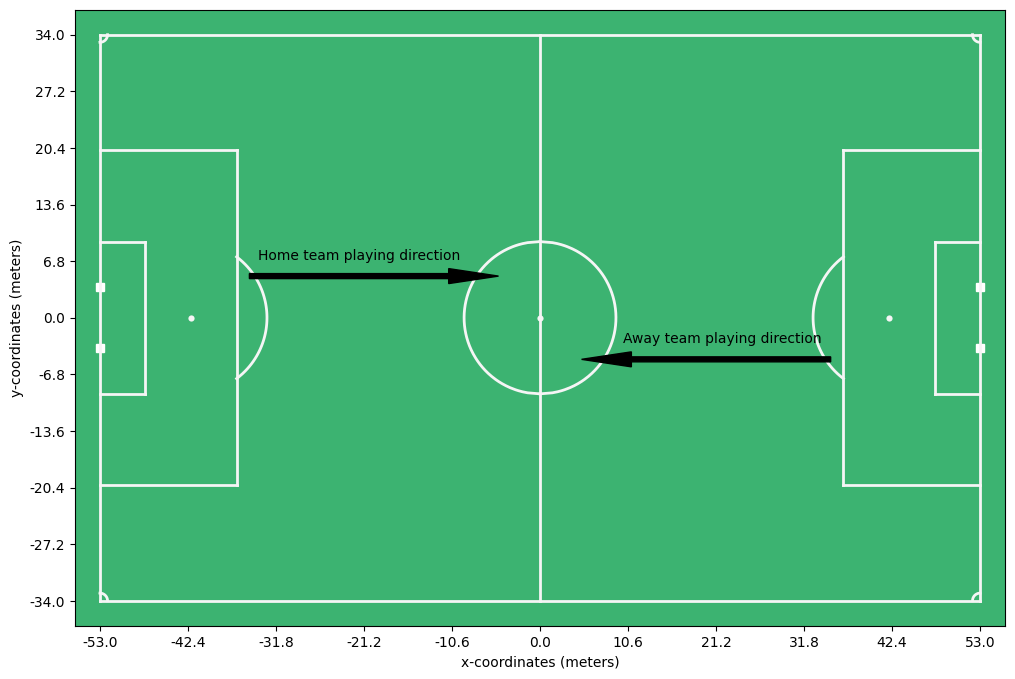

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Arrow
from databallpy.visualize import plot_soccer_pitch


fig, ax = plot_soccer_pitch()

# Add x and y ticks and labels
ax.set_xticks(np.linspace(-53, 53, 11))
ax.set_yticks(np.linspace(-34, 34, 11))
ax.set_xticklabels(np.round(np.linspace(-53, 53, 11), 1))
ax.set_yticklabels(np.round(np.linspace(-34, 34, 11), 1))

ax.set_xlabel("x-coordinates (meters)")
ax.set_ylabel("y-coordinates (meters)")

# Add playing direciont
ax.add_patch(Arrow(-35, 5, 30, 0, width=3, color="k"))
ax.text(-34, 7, "Home team playing direction")
ax.add_patch(Arrow(35, -5, -30, 0, width=3, color="k"))
ax.text(10, -3, "Away team playing direction", )

plt.show()

```{note}
In rare cases you might be interested in which halves the tracking data was swapped. This can be found in `match._periods_changed_playing_direction` which return a list with period ids where the home team actually played from right to left, instead of left to right (as it is represented in the tracking data)
```
```{important}
This is the only preprocessing that is done to the tracking data:
- Scaling of coordinate so that they represent meters
- Translating of coordinate so that the center of the pitch is at (0, 0)
- Mirroring the data for certain periods (halves) so that the home team is represented as playing from left (low x values) to right (high x values) for **the full match** 
```

## Event data

- event data
- event data provider

In [7]:
print(f"The match event data provider = {match.event_data_provider}")
print(f"The event data columns: {match.event_data.columns}")

The match event data provider = metrica
The event data columns: Index(['event_id', 'type_id', 'databallpy_event', 'period_id', 'minutes',
       'seconds', 'player_id', 'player_name', 'team_id', 'outcome', 'start_x',
       'start_y', 'to_player_id', 'to_player_name', 'end_x', 'end_y',
       'td_frame', 'metrica_event', 'datetime'],
      dtype='object')


Again, you can see that we are just dealing with a familiar pandas dataframe, nothing to be afraid of. Let's go through all the columns before we take a look at the data:

- `event_id`: a unique id (usually an integer) for the event.
- `type_id`: an id indicating the type of event (often only used by event data providers themselves).
- `databallpy_event`: a string indicating the event. Since we aim to create a standardized format of event data, we need to translate the

event data from the provider, in this case Metrica, to a standard event type, in this case that is `databallpy_event`. It currently can only have the values `pass`, `shot`, or `dribble`. For any other event, the value will be `None`. We aim to increase the number of databallpy events in future versions to be more complete.

- `period_id`: the period that the event happened in. `1` indicating the first half and `2` the second half.
- `minutes`: the number of minutes in the match at the time of the event.
- `seconds`: the number of seconds in the match at the time of the event.
- `player_id`: an unique id of the player involved in the event.
- `player_name`: a string with the name of the player.
- `team_id`: an unique id for which team the event belonged to.
- `outcome`: a boolian indicating if the `databallpy_event` was successful (`True`) or not (`False`).
- `start_x` and `start_y`: the coordinate, indicated by the event data provider, where the event took place. Note that these coordinates are scaled to fit the tracking data.
- `metrica_event`: Since `databallpy_event` may not capture all events, we always keep in the original event data of the provider to make sure no data is lost in the process.
- `datetime`: a datatime object used to indicate when the event took place.
  
As you probably have notices, I skipped a few columns. That is because these columns are specific for Metrica, not all event data providers provide this data, and therefore these columns are not present in all event data dataframes.

- `to_player_id` and `to_player_name`: Metrica sometimes indicate to which player the ball was passed. Since metrica indicates this information, we add it in the dataframe, but this column is not present for event data providers that do not indicate this in their data.
- `end_x` and `end_y`: the coordinate, indicated by the event data provider, where the event ended. Note that these coordinates are scaled to fit the tracking data. Also, this is again Metrica specific data, not all event data providers provide this data.
- `td_frame`: since this match uses tracking and event data from `Metrica`, the two are already synchronised. The `td_frame` indicates what frame in the tracking data belongs to the event to get contextual information of that event.


Here is an example of what an event in the event data looks like:

In [8]:
print(match.event_data.iloc[13])

event_id                                          14
type_id                                            1
databallpy_event                                pass
period_id                                          1
minutes                                            0
seconds                                        28.88
player_id                                       3570
player_name                                 Player 3
team_id                                      FIFATMA
outcome                                            1
start_x                                     -32.9574
start_y                                    -24.63232
to_player_id                                    3578
to_player_name                             Player 11
end_x                                      -48.33255
end_y                                       -8.37284
td_frame                                         722
metrica_event                                   pass
datetime            2019-02-21 03:30:35.840000

```{important}
This is the only preprocessing that is done to the event data:
- Scaling of coordinate so that they represent meters
- Translating of coordinate so that the center of the pitch is at (0, 0)
- Mirroring the data for specific events so that the home team is represented as playing from left (low x values) to right (high x values) for **the full match**.
```

# Conclusion

In this chapter we have gone over the loading of a match, and the different attributes that are stored in the `Match` object. We have seen that the `Match` object contains all information you need to get started with your analysis. As you have seen, the `Match` is really all you need to get started with your analysis. However, in the next chapter we will go over some additional features that are available in the package. 

```{note}
If you have any questions, suggestions, or improvements, please open an issue [here](https://www.github.com/Alek050/databallpy/issues/)
```